<h1>Importing Libraries</h1>

Please run "pip install -r requirements.txt" from the root of the project 

In [32]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\chanj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [33]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
import warnings
# Disable all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

<h1>NumPy vs Pandas</h1>

A Pandas DataFrame is a two-dimensional, tabular, mutable data structure in Python that can store tabular data containing objects of different data types.

A NumPy array is a type of multi-dimensional data structure in Python which can store objects of similar data types.

<h1>Titanic Dataset</h1>

https://www.kaggle.com/c/titanic/data

<h2> Variable Notes </h2>

| Variable  | Definition                  | Key                                            |
|-----------|-----------------------------|------------------------------------------------|
| survival  | Survival                    | 0 = No, 1 = Yes                                |
| pclass    | Ticket class                | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex       | Sex                         |                                                |
| Age       | Age in years                |                                                |
| sibsp     | # of siblings / spouses aboard the Titanic |                                      |
| parch     | # of parents / children aboard the Titanic |                                      |
| ticket    | Ticket number               |                                                |
| fare      | Passenger fare              |                                                |
| cabin     | Cabin number                |                                                |
| embarked  | Port of Embarkation         | C = Cherbourg, Q = Queenstown, S = Southampton |


<h1>Data Preparation</h1>

Here the goal is to make the necessary manipulations so that the models will accept them.
This includes filling in Nan (Not a number) values in the pandas.

In [34]:

label_encoder = preprocessing.LabelEncoder()
current_directory = os.getcwd()
try:
    titanic = pd.read_csv(current_directory+'\\titanic.csv')
except FileNotFoundError:
    titanic = pd.read_csv(current_directory+'/titanic.csv')
    

# Operations to create a distinct value that I know I can encode.
titanic["Cabin"].fillna("Not Known")
titanic["Embarked"].fillna("Not Known")
titanic["Sex"].fillna("Not Known")
titanic["Ticket"].fillna("Not Known")
titanic["Name"].fillna("Not Known")

# Encoding the values in these columns then replacing the columns with the encoded version
titanic["Cabin"] = label_encoder.fit_transform(titanic["Cabin"])
titanic["Name"] = label_encoder.fit_transform(titanic["Name"])
titanic["Sex"] = label_encoder.fit_transform(titanic["Sex"])
titanic["Ticket"] = label_encoder.fit_transform(titanic["Ticket"])
titanic["Embarked"] = label_encoder.fit_transform(titanic["Embarked"])

titanic_labels = titanic["Survived"]
# The Survived column can be disgarded now as we have separated it from the features into its own variable.
titanic = titanic.drop("Survived", axis=1)

<h1>Data Splitting and Final Data Manipulations </h1>

A reason to do fillna that would uses an aggregate (sum, mean, min, etc.) is to prevent data leaking between the training set and test set!

In [35]:
# Play around and see what happens to the models when you change the test-training ratios
train_size = 0.8
test_size = 1 - train_size
assert train_size + test_size == 1

# I decided to drop the Name column as I believe it to generate unique values when encoded 
titanic.drop("Name",axis=1, inplace=True)

# train_test_split this is a method that scikit-learn provides in the library
titanic_train, titanic_test, labels_train, labels_test = train_test_split(titanic,titanic_labels , train_size=train_size, random_state=42)

In [36]:
'''
both ways are valid
we do fillna here instead of above as we want to avoid data leaking since an average would 
use all the data in the column before splitting
'''
titanic_train["Age"].fillna(titanic_train["Age"].mean(), inplace=True) # filling Nan of Age for Training data

titanic_test["Age"] = titanic_test["Age"].fillna(titanic_test["Age"].mean()) # filling Nan of Age for Test data

<h1>Quick Check</h1>

Always good idea to validate that your data manipulations/operations expectations matches your results.

In [37]:
titanic.loc[titanic["Age"].isna()==True]
# We know that Age has NaN (Not a Number) values so let's check 

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,3,1,NaN,0,0,275,8.4583,147,1
17,18,2,1,NaN,0,0,151,13.0000,147,2
19,20,3,0,NaN,0,0,184,7.2250,147,0
26,27,3,1,NaN,0,0,179,7.2250,147,0
28,29,3,0,NaN,0,0,283,7.8792,147,1
...,...,...,...,...,...,...,...,...,...,...
859,860,3,1,NaN,0,0,178,7.2292,147,0
863,864,3,0,NaN,8,2,568,69.5500,147,2
868,869,3,1,NaN,0,0,309,9.5000,147,2
878,879,3,1,NaN,0,0,363,7.8958,147,2


In [38]:
titanic_train.loc[titanic_train["Age"].isna()==True]
# no rows should appear

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [39]:
titanic_test.loc[titanic_test["Age"].isna()==True]
# no rows should appear

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [40]:
def metrics(true_y,prediction_y):
    print(f"Accuracy: {accuracy_score(y_true=true_y,y_pred= prediction_y)}")
    print(f"Precision (Weighted): {precision_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"Recall (Weighted): {recall_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"F1 Score (Weighted): {f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division='warn'))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

def compareModels(true_y,prediction_y):
    return [accuracy_score(y_true=true_y,y_pred= prediction_y),
    precision_score(y_true=true_y,y_pred= prediction_y, average='weighted'),
    recall_score(y_true=true_y,y_pred= prediction_y, average='weighted'),
    f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')]

<h2>2.2 Training and Test data split</h2>

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB)
with the default parameters.</h2>

Multinomial Naive Bayes is a probabilistic machine learning algorithm used for text classification and natural language processing tasks. It's based on Bayes' theorem and makes a crucial assumption of conditional independence between features (words or tokens in the case of text data).

This algorithm is particularly well-suited for text-related applications, such as spam email detection, sentiment analysis, and document categorization. It calculates the probability of a document belonging to a specific class by considering the frequency of words in that document and their conditional probabilities within each class.

The "Multinomial" aspect of Multinomial Naive Bayes refers to the type of probability distribution it assumes for features. It's ideal for handling discrete data, such as word counts in text. The "Naive" part comes from the assumption that features are conditionally independent, simplifying the model despite not always holding true in reality.

In summary, Multinomial Naive Bayes is a powerful and widely used tool for text classification tasks, offering a practical way to make probabilistic predictions based on the presence and frequency of words in text documents. Its simplicity and effectiveness make it a valuable asset in various natural language processing applications.

$P(y | x) = {(P(x | y) * P(y)) \over P(x)}$

In [41]:
classifier = MultinomialNB()
if (os.path.exists('models/MNB1_model.pickle')):
    pickle_in = open('models/MNB1_model.pickle','rb')
    MNBclf = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(titanic_train, labels_train)
    with open('models/MNB1_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1_model.pickle','rb')
    MNBclf = pickle.load(pickle_in)
pickle_in.close()

pickle file used


Accuracy: 0.7150837988826816
Precision (Weighted): 0.7123686733928125
Recall (Weighted): 0.7150837988826816
F1 Score (Weighted): 0.7126068335103507
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       105
           1       0.67      0.61      0.64        74

    accuracy                           0.72       179
   macro avg       0.71      0.70      0.70       179
weighted avg       0.71      0.72      0.71       179



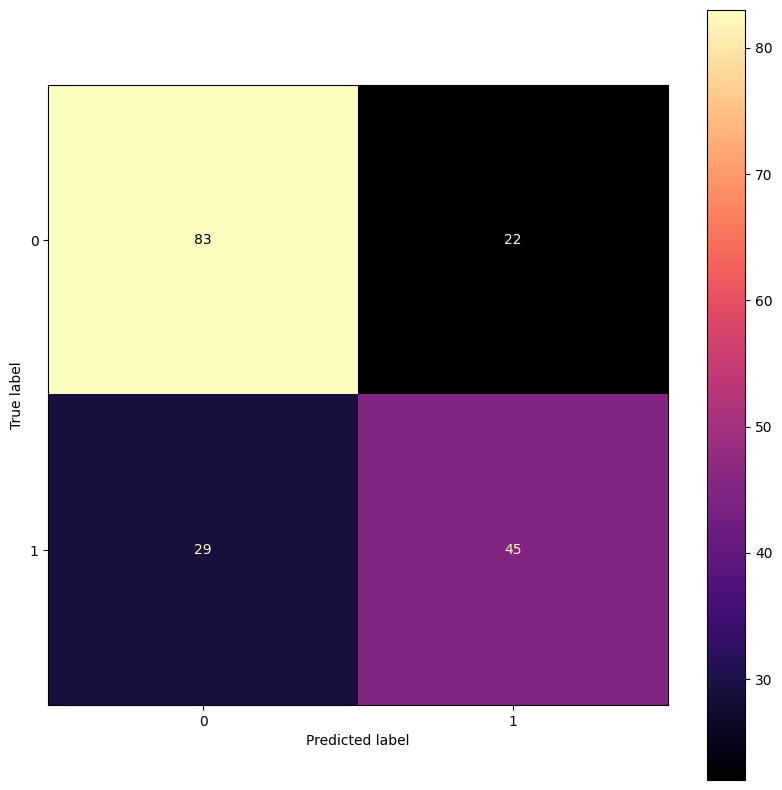

In [42]:
labels_titanic_predict = MNBclf.predict(titanic_test)

metrics(labels_test, labels_titanic_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=labels_test, y_pred= labels_titanic_predict))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax,cmap='magma')

<h2>Decision Tree (tree.DecisionTreeClassifier) with the default parameters.</h2>

Decision trees are a fundamental machine learning algorithm used for both classification and regression tasks. They operate by recursively partitioning the data into subsets based on the most informative features, creating a tree-like structure where each internal node represents a decision based on a feature, and each leaf node denotes the final prediction or outcome.

Decision trees are known for their interpretability, making them valuable for understanding the underlying logic of a model. They work by selecting the feature that best separates the data at each node, typically using metrics like Gini impurity or information gain for classification tasks and mean squared error for regression.

One of the significant advantages of decision trees is their ability to handle both numerical and categorical data. However, they can be prone to overfitting when the tree becomes too deep and complex. To mitigate this, techniques like pruning and setting a maximum depth are often used.

Ensemble methods, such as Random Forests and Gradient Boosting, are based on decision trees and aim to enhance their performance and generalization by combining multiple trees.

In summary, decision trees are intuitive and versatile tools in machine learning, appreciated for their interpretability and ability to handle various types of data. They are a building block for more advanced ensemble models, making them a crucial concept in the field of data science and predictive modeling.

$Gini(D) = 1 - Σ(p_i^2)$ 

$Entropy(D) = -Σ(p_i * log2(p_i))$

In [43]:
classifier = DecisionTreeClassifier(criterion="entropy") # default measure of chaos is gini in scikit-learn
if (os.path.exists('models/DT1_model.pickle')):
    pickle_in = open('models/DT1_model.pickle','rb')
    DTclf = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(titanic_train, labels_train)
    with open('models/DT1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT1_model.pickle','rb')
    DTclf = pickle.load(pickle_in)
pickle_in.close()

pickle file used


Accuracy: 0.7039106145251397
Precision (Weighted): 0.7023544120089875
Recall (Weighted): 0.7039106145251397
F1 Score (Weighted): 0.7029327573997248
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       105
           1       0.65      0.62      0.63        74

    accuracy                           0.70       179
   macro avg       0.69      0.69      0.69       179
weighted avg       0.70      0.70      0.70       179



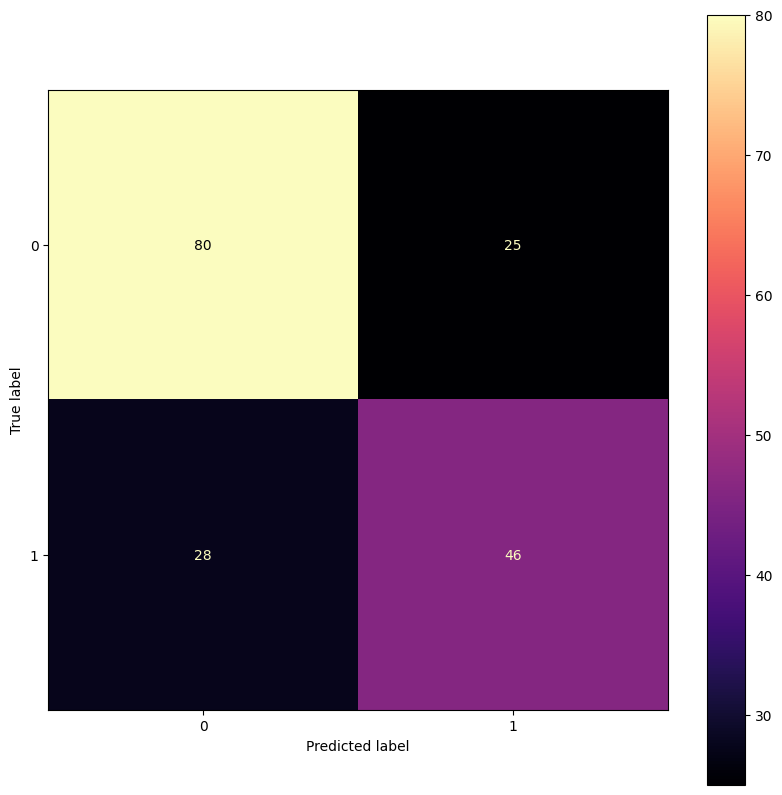

In [44]:
labels_titanic_predict = DTclf.predict(titanic_test)

metrics(labels_test, labels_titanic_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=labels_test, y_pred= labels_titanic_predict))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax,cmap='magma')


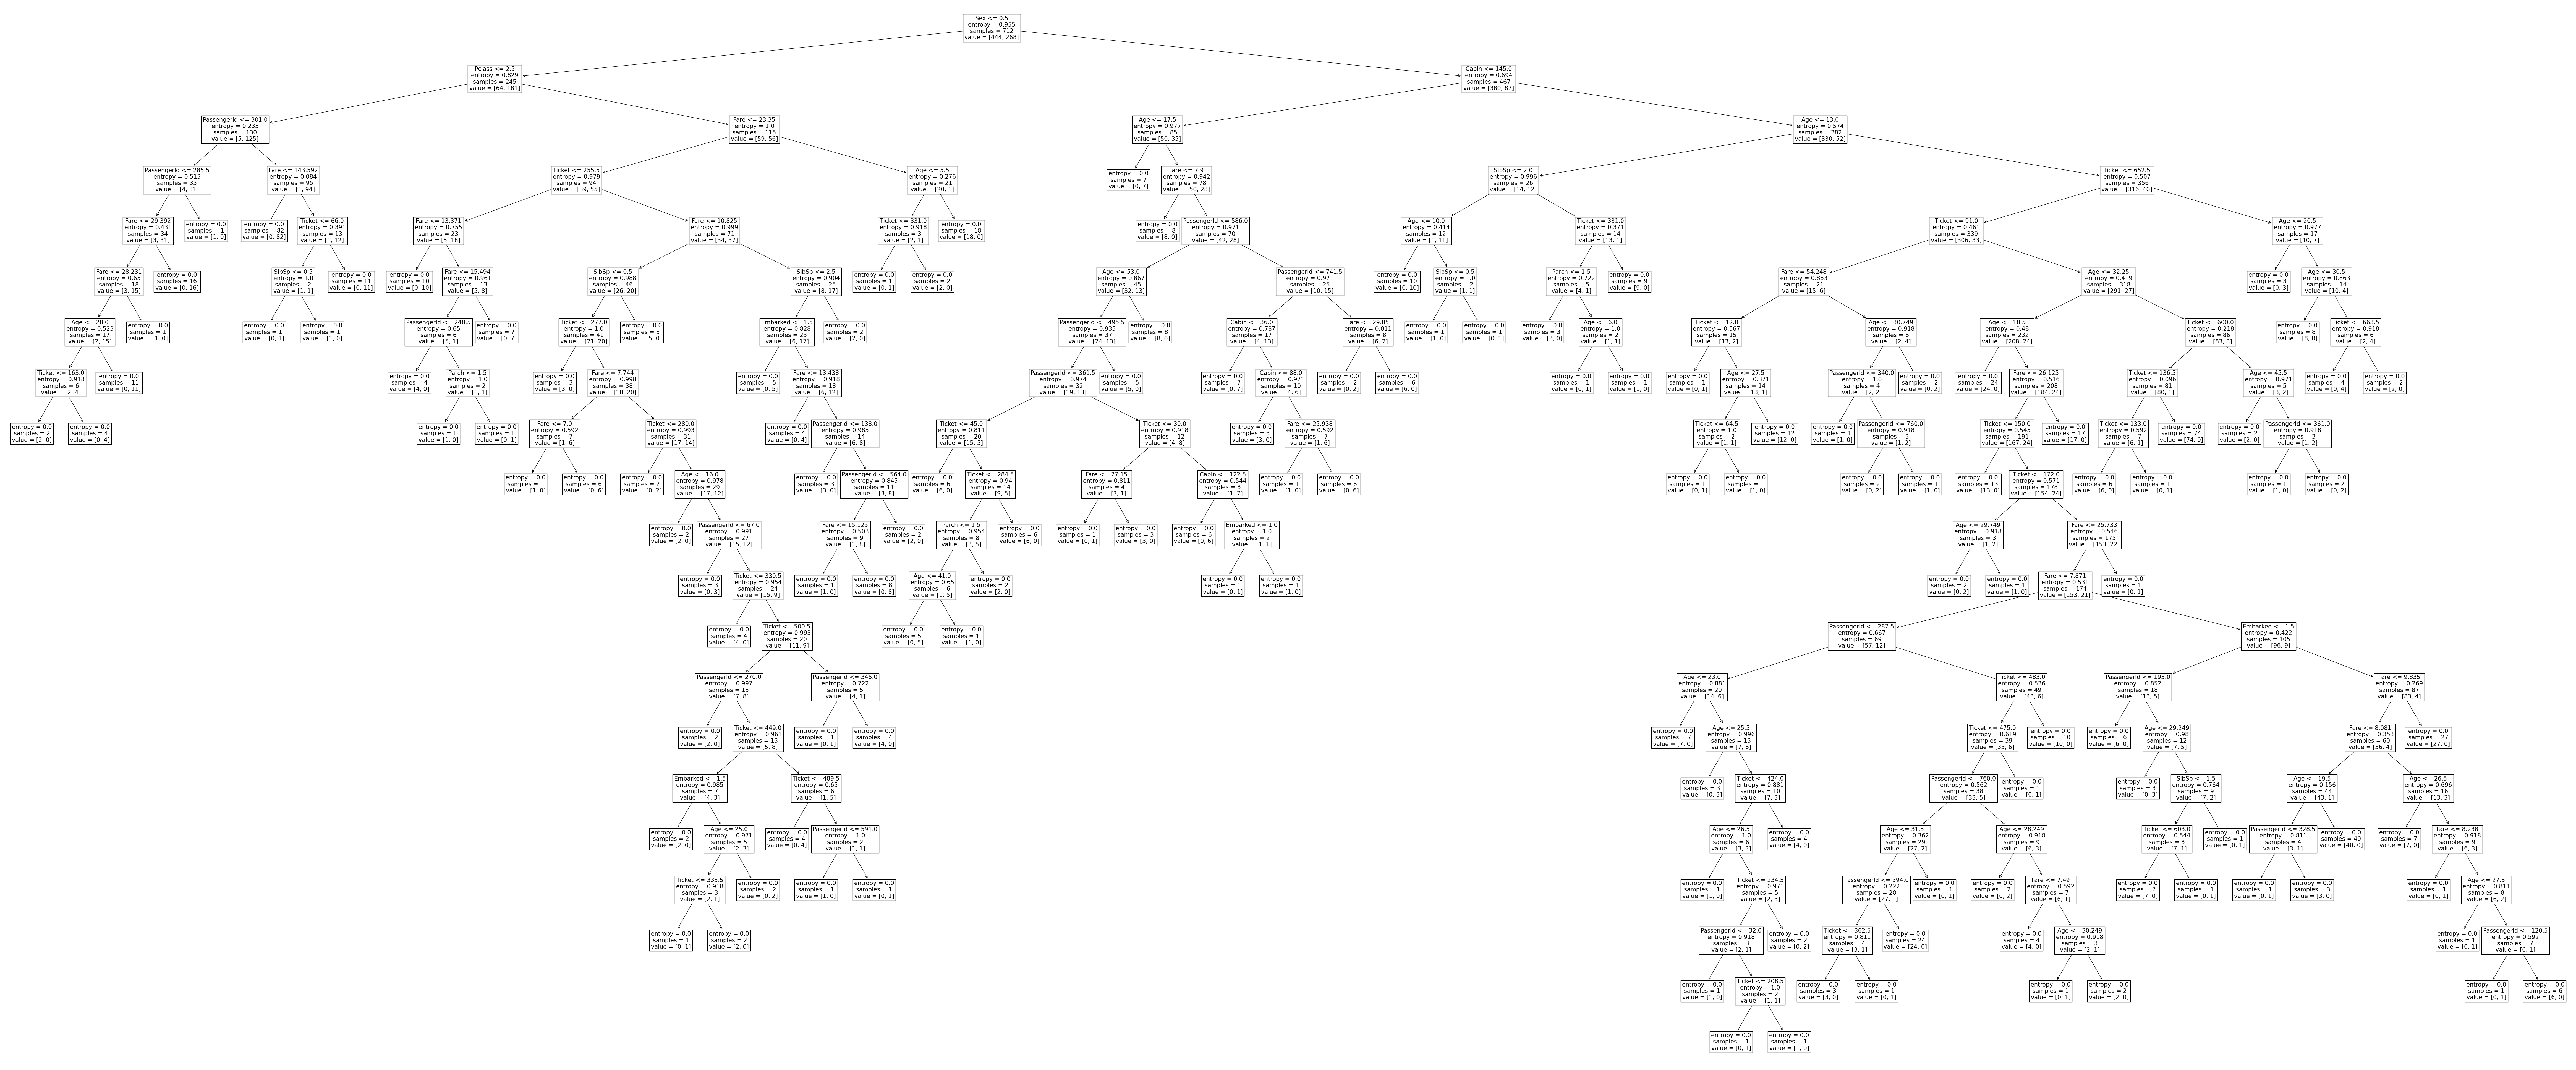

In [45]:
plt.figure(figsize=(120,50))  # set plot size (denoted in inches)
plot_tree(DTclf, feature_names= titanic_train.columns, fontsize=15)
plt.show()

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.</h2>

A Multi-Layered Perceptron (MLP) is a fundamental artificial neural network architecture used for a wide range of machine learning tasks, particularly in deep learning. It consists of multiple layers of interconnected artificial neurons (perceptrons) and is characterized by its feedforward nature, where information flows from input to output layers.

MLPs are known for their ability to model complex, non-linear relationships within data. The architecture typically comprises an input layer, one or more hidden layers, and an output layer. Neurons within each layer are connected to neurons in subsequent layers by weighted connections. The activation function, often a non-linear function like the sigmoid or ReLU (Rectified Linear Unit), introduces non-linearity into the model, enabling it to capture intricate patterns.

Training an MLP involves using techniques like backpropagation and gradient descent to adjust the weights and biases in the network to minimize the error between the predicted and actual outputs. This training process allows MLPs to learn complex representations from data, making them versatile for tasks such as image classification, natural language processing, and regression.

MLPs, when deep (comprising multiple hidden layers), are often referred to as deep neural networks and are at the core of deep learning, driving breakthroughs in areas like computer vision, speech recognition, and more. Their success is attributed to their capacity to automatically extract and represent hierarchical features from data.

In summary, the Multi-Layered Perceptron is a powerful and widely-used neural network architecture that forms the foundation of deep learning. It excels in capturing complex patterns in data and has been instrumental in revolutionizing various fields by enabling the development of highly accurate and sophisticated machine learning models.

Through explanation of the math can be found online: https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi.

Forward propagation the most general equation you will see is:

$z = (w * x) + b$

$y_i = activation(z)$

Backward propagation is a bunch of derivatives to modify the weights for each node

In [46]:
classifier = MLPClassifier(random_state = 19)
if (os.path.exists('models/MLP1_model.pickle')):
    pickle_in = open('models/MLP1_model.pickle','rb')
    MLPclf = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(titanic_train, labels_train)
    with open('models/MLP1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP1_model.pickle','rb')
    MLPclf = pickle.load(pickle_in)
pickle_in.close()

pickle file used


In [47]:
# This can be used 
# print(np.shape(titanic_train))
# print(np.shape(labels_train))

Accuracy: 0.7318435754189944
Precision (Weighted): 0.7395820006539015
Recall (Weighted): 0.7318435754189944
F1 Score (Weighted): 0.7180408586494387
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       105
           1       0.77      0.50      0.61        74

    accuracy                           0.73       179
   macro avg       0.74      0.70      0.70       179
weighted avg       0.74      0.73      0.72       179



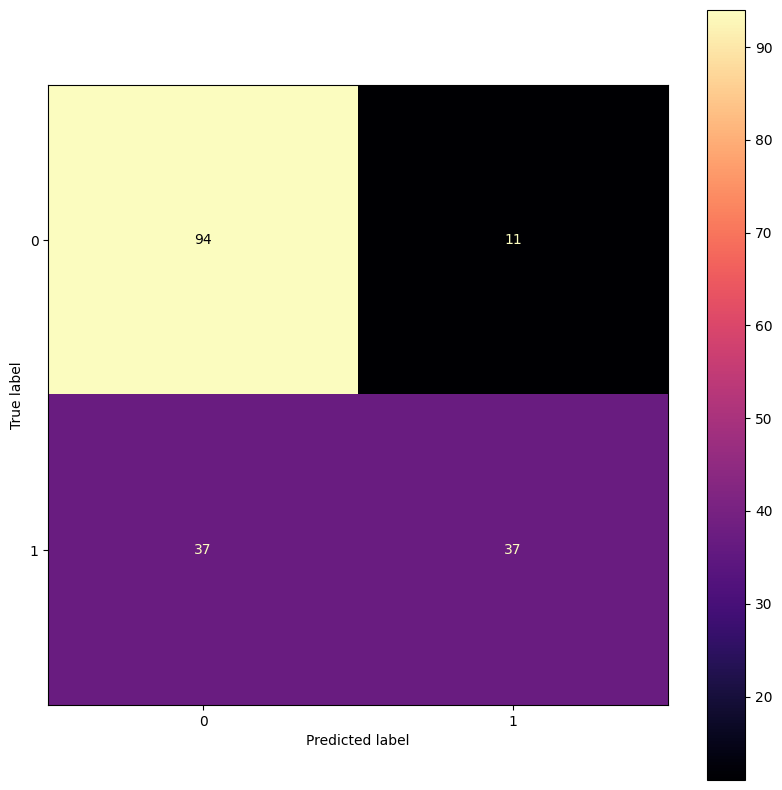

In [48]:
labels_titanic_predict = MLPclf.predict(titanic_test)
metrics(labels_test, labels_titanic_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=labels_test, y_pred= labels_titanic_predict))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax,cmap='magma')

<h1>Cross Validation/Model Validation</h1>

In cross-validation, the available dataset is split into multiple subsets or "folds." The model is trained on a portion of the data and tested on another, repeating this process several times to ensure that each data point serves as both training and testing data. Common methods include k-fold cross-validation, leave-one-out, and stratified cross-validation, depending on the specific use case. 

**Testing on the same data is a methodological mistake**. A model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data.
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score

In [49]:
# note that we do not split the test and training here as this will create various training and test data chunks
titanic = pd.concat([titanic_test, titanic_train])

scores = cross_val_score(DTclf,titanic,titanic_labels, cv=10, scoring = "recall", n_jobs=-1)
print(f"Mean Scoring: {scores.mean()} between 0 and 1")

Mean Scoring: 0.41831932773109237 between 0 and 1


https://scikit-learn.org/stable/_images/grid_search_cross_validation.png

<h1>Your Turn</h1>

Go find a model you want to use on this data<br>

Simple things you can try:
* manually selecting hyperparameters
* change the features that are being used
* try unsupervised learning 

If you don't know where to start feel free to discuss with myself or those around you!

All models and fancy things can be found here 
https://scikit-learn.org/stable/modules/classes.html

Need help picking a model?
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

In [50]:
# from sklearn.neighbors import KNeighborsClassifier
# classifier = KNeighborsClassifier(n_neighbors=2, weights="distance") # define a model
classifier = MODEL() # define a model 
modelName = "UserModel" # name your model

if (os.path.exists(f'models/{modelName}.pickle')):
    pickle_in = open(f'models/{modelName}.pickle','rb')
    user_clf = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(titanic_train, labels_train)
    with open(f'models/{modelName}.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open(f'models/{modelName}.pickle','rb')
    user_clf = pickle.load(pickle_in)
pickle_in.close()


NameError: name 'MODEL' is not defined

In [ ]:
labels_titanic_predict = user_clf.predict(titanic_test)
user_clf.best_estimator_
metrics(labels_test, labels_titanic_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=labels_test, y_pred= labels_titanic_predict))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax,cmap='magma')

<h1>More Resources</h1>


Sci-kit learn linear models [Link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model).

Sci-kit learn clustering models [Link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster).

Sci-kit learn ensemble models [Link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble).

<h1>Example of Hyperparameter Search</h1>

Hyperparameters are parameters that are not learned from the data but are set before training begins. Their values significantly impact a model's performance, and finding the right combination of hyperparameters can make the difference between a mediocre and a highly accurate model.

<h2>Decision Tree Classifier found using GridSearchCV</h2>

Hyperparameters are called attributes in scikit-learn documentation <br>

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier 

In [ ]:
parameters = {"criterion":("gini","entropy"),"max_depth":(100,3,10,5),"min_samples_split":(7,12,5,30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters,n_jobs=-1, scoring = "recall")

if (os.path.exists('models/DT1GridCV_model.pickle')):
    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    DTclfGrid = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(titanic_train, labels_train)
    with open('models/DT1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    DTclfGrid = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
scores = cross_val_score(DTclfGrid.best_estimator_,titanic,titanic_labels, cv=10, scoring = "recall")
print(f"Mean Scoring: {scores.mean()} between 0 and 1")

In [ ]:
labels_titanic_predict = DTclfGrid.best_estimator_.predict(titanic_test)

print(f"Best estimator: {DTclfGrid.best_estimator_}")
metrics(labels_test, labels_titanic_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=labels_test, y_pred= labels_titanic_predict))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax,cmap='magma')

In [ ]:
plt.figure(figsize=(15,15))  # set plot size (denoted in inches)
plot_tree(DTclfGrid.best_estimator_, feature_names= titanic_train.columns, fontsize=10)
plt.show()